In [1]:
import sys
import os

sys.path.append('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/training')


In [2]:
import pandas as pd
import numpy as np
import torch 
from torch import from_numpy
import torch.nn as nn
from torchvision.models import convnext_small, ConvNeXt_Small_Weights
from torch.utils.data import TensorDataset, DataLoader
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tl_tools import *
setup_mixed_precision()

Mixed precision policy set to: mixed_float16



In [3]:
test_dir = '/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/data/USTC_SmokeRS/processed/test'
test_datagen = ImageDataGenerator(rescale=1./255)
test = test_datagen.flow_from_directory(test_dir, color_mode= 'rgb', batch_size = 16, shuffle= True, seed = 1, target_size=(256, 256))

X_test, y_test = test_splits(test)

X_test = from_numpy(X_test.numpy()).permute(0, 3, 1, 2)
y_test = from_numpy(y_test.numpy())

test_dataset = TensorDataset(X_test, y_test)
test_loader = DataLoader(test_dataset, batch_size = 16, shuffle = False)

Found 1245 images belonging to 6 classes.
Number of batches in the test data: 78
Batch size of a single batch 16
Number of samples in the test dataset 1245



2024-11-28 13:31:35.309740: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-11-28 13:31:35.309769: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 18.00 GB
2024-11-28 13:31:35.309777: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 6.00 GB
2024-11-28 13:31:35.309945: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-11-28 13:31:35.309957: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Shape of image test set: (1245, 256, 256, 3)

Shape of label test set: (1245, 6)


In [4]:
convnext = convnext_small(weights=ConvNeXt_Small_Weights.IMAGENET1K_V1)
convnext.classifier = nn.Sequential(
    nn.Flatten(),     
    
    #FC 1                       
    nn.Linear(in_features=768, out_features=64),   
    nn.ReLU(),
    nn.BatchNorm1d(64), 
    nn.Dropout1d(p=0.3), 
           
    #FC 2                                           
    nn.Linear(in_features=64, out_features=32),
    nn.ReLU(), 
    nn.BatchNorm1d(32),  
    nn.Dropout1d(p=0.3), 
    
    #Softmax
    nn.Linear(in_features=32, out_features=6),  
    nn.Softmax(dim=1)                                           
)


for param in convnext.features.parameters(): 
    param.requires_grad = False

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
convnext = convnext.to(device)

# Load the saved weights
checkpoint = torch.load('/Users/pimpijnenburg/Desktop/Thesis/USTC_SmokeRS_dataset/code/transfer_learning/trained_models/convnext_model.pth', weights_only=False)
convnext.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [5]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

total_params = count_parameters(convnext)

optimizer_params = sum(
    state['exp_avg'].numel() + state['exp_avg_sq'].numel()
    for state in checkpoint['optimizer_state_dict']['state'].values()
)

actual_params = total_params - optimizer_params
print(f'Parameters: {actual_params:,}')

Parameters: 49,401,466


In [6]:
import time

In [7]:
n_runs = 10
inference_times = list()

true_labels = list()
with torch.no_grad():
    for _, targets in test_loader:
        true_labels.extend(torch.argmax(targets, dim=1).numpy())
true_labels = np.array(true_labels)

convnext.eval()

#Warmup pred
with torch.no_grad():
    for inputs, targets in test_loader:
        inputs = inputs.to(device)
        _ = convnext(inputs)

for i in range(n_runs):
    predictions = list()
    start_time = time.time()
    
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs = inputs.to(device)
            outputs = convnext(inputs)
            _, predicted = torch.max(outputs, 1)
            predictions.extend(predicted.cpu().numpy())
    
    end_time = time.time()
    inference_times.append(end_time - start_time)

predictions = np.array(predictions)  # keeping last run's predictions

In [8]:
avg_time = np.mean(inference_times)
std_time = np.std(inference_times)
time_per_image = avg_time / len(true_labels)  # using actual number of images

print(f"Average inference time: {avg_time:.2f} ± {std_time:.2f} seconds")
print(f"Average time per image: {time_per_image*1000:.2f} milliseconds")

Average inference time: 15.12 ± 0.05 seconds
Average time per image: 12.15 milliseconds


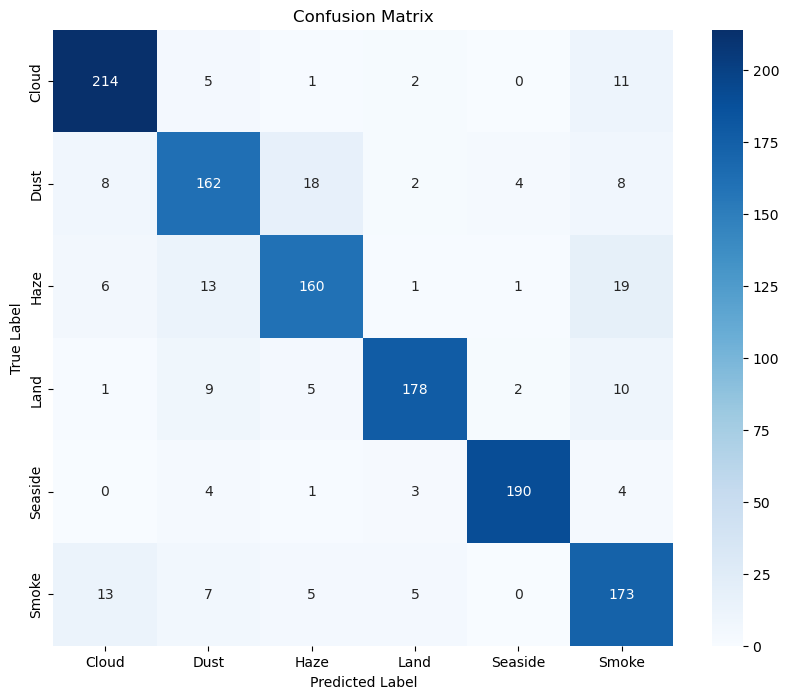

In [9]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

class_labels = list(test.class_indices.keys())
confusion_matrix = confusion_matrix(true_labels, predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [10]:
y_pred_proba = list()
convnext.eval()
with torch.no_grad():
   for inputs, targets in test_loader:
       inputs = inputs.to(device)
       outputs = convnext(inputs)
       probs = outputs.cpu().numpy()
       y_pred_proba.append(probs)

y_pred_proba = np.vstack(y_pred_proba)

In [11]:
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import label_binarize

n_classes = len(class_labels)
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)


y_true_binary = label_binarize(true_labels, classes = np.arange(n_classes))

metrics = ['Precision', 'Recall', 'F1-score', 'False Negative Rate', 'ROC-AUC']

df_metrics = pd.DataFrame(index=metrics, columns=class_labels)

for i in range(n_classes):
    df_metrics.iloc[0, i] = TP[i] / (TP[i] + FP[i])
    df_metrics.iloc[1, i] = TP[i] / (TP[i] + FN[i])
    df_metrics.iloc[2, i] = 2 * TP[i] / (2 * TP[i] + FP[i] + FN[i])
    df_metrics.iloc[3, i] = FN[i] / (FN[i] + TP[i])  # False Negative Rate
    df_metrics.iloc[4, i] = roc_auc_score(y_true_binary[:, i], y_pred_proba[:, i], average= 'weighted')
    
def round_fn(input): 
    return round(input, 2)

df_metrics = df_metrics.map(round_fn)
df_metrics

,Cloud,Dust,Haze,Land,Seaside,Smoke
Precision,0.88,0.81,0.84,0.93,0.96,0.77
Recall,0.92,0.80,0.80,0.87,0.94,0.85
F1-score,0.90,0.81,0.82,0.90,0.95,0.81
False Negative Rate,0.08,0.20,0.20,0.13,0.06,0.15
ROC-AUC,0.98,0.97,0.98,0.98,1.00,0.96


In [12]:
from sklearn.metrics import accuracy_score

print(f'Accuracy Score: {accuracy_score(true_labels, predictions):.2f}')
for index, row in df_metrics.iterrows(): 
    row_mean = row.mean()
    print(f'Average {index} Score: {row_mean:.2f}')

Accuracy Score: 0.87
Average Precision Score: 0.86
Average Recall Score: 0.86
Average F1-score Score: 0.86
Average False Negative Rate Score: 0.14
Average ROC-AUC Score: 0.98
